In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard imports
import numpy as np

# pertpy is needed to download the Kang data
import pertpy
import scanpy as sc

# This will download the data to ./data/kang_2018.h5ad
adata = pertpy.data.kang_2018()
# Store counts separately in the layers
adata.layers["counts"] = adata.X.copy()

/Users/mkeller/software/miniconda3/envs/pylemur/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
import pylemur.pp.basic

adata.layers["logcounts"] = pylemur.pp.basic.shifted_log_transform(adata.X)

In [4]:
import dask.array as da

def get_input_arr():
    return da.from_array(adata.layers["logcounts"])

In [5]:
x = np.array([[1, 2, 3]])

In [6]:
np.squeeze(x).shape

(3,)

In [7]:
A = np.ones((24673, 2))
B = np.ones((24673,))

In [8]:
B

array([1., 1., 1., ..., 1., 1., 1.])

In [9]:
adata

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts', 'logcounts'

In [10]:
import pylemur

model = pylemur.tl.LEMUR(adata, get_input_arr, design = "~ label", n_embedding=15, layer = "logcounts")
model.fit()
model.align_with_harmony()
print(model)

Centering the data using linear regression.
Find base point
Fit regression on latent spaces
Find shared embedding coordinates


/Users/mkeller/research/dbmi/vitessce/pyLemur/src/pylemur/tl/alignment.py:142: RuntimeWarning: divide by zero encountered in divide
  theta = theta * (1 - np.exp(-((N_b / (nclust * tau)) ** 2)))
2024-12-10 10:57:25,000 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-12-10 10:57:26,665 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-12-10 10:57:26,732 - harmonypy - INFO - Stopped before convergence


Alignment iteration 0
Alignment iteration 1
Alignment iteration 2
Alignment iteration 3
Alignment iteration 4
Alignment iteration 5
Alignment iteration 6
Converged
LEMUR model with 15 dimensions


In [27]:
# The model.cond(**kwargs) call specifies the condition for the prediction
ctrl_pred = model.predict(new_condition=model.cond(label="ctrl"))
stim_pred = model.predict(new_condition=model.cond(label="stim"))

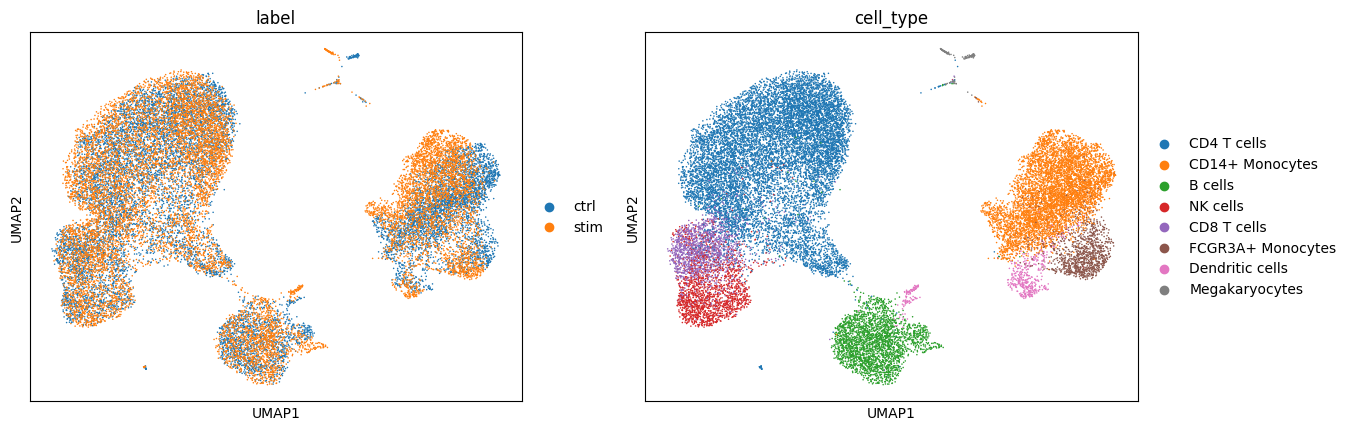

In [28]:
# Recalculate the UMAP on the embedding calculated by LEMUR
adata.obsm["embedding"] = model.embedding
sc.pp.neighbors(adata, use_rep="embedding")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["label", "cell_type"])

In [ ]:
import matplotlib.pyplot as plt
adata.layers["diff"] = (stim_pred - ctrl_pred)
# Also try CXCL10, IL8, and FBXO40
sel_gene = "CXCL10"

fsize = plt.rcParams['figure.figsize']
fig = plt.figure(figsize=(fsize[0] * 3, fsize[1]))
axs = [fig.add_subplot(1, 3, i+1) for i in range(3)]
for ax in axs:
    ax.set_aspect('equal')
sc.pl.umap(adata, layer="diff", color=[sel_gene], cmap = plt.get_cmap("seismic"), vcenter=0,
    vmin=-4, vmax=4, title="Pred diff (stim - ctrl)", ax=axs[0], show=False)
sc.pl.umap(adata[adata.obs["label"]=="ctrl"], layer="logcounts", color=[sel_gene], vmin = 0, vmax =4,
    title="Ctrl expr", ax=axs[1], show=False)
sc.pl.umap(adata[adata.obs["label"]=="stim"], layer="logcounts", color=[sel_gene], vmin = 0, vmax =4,
    title="Stim expr", ax=axs[2])


In [ ]:
def rowMeans_per_group(X, group):
    uniq = np.unique(group)
    res = np.zeros((len(uniq), X.shape[1]))
    for i, e in enumerate(uniq):
        res[i,:] = X[group == e,:].sum(axis=0) / sum(group == e)
    return res

adata_ctrl = adata[adata.obs["label"] == "ctrl",:]
adata_stim = adata[adata.obs["label"] == "stim",:]
ctrl_expr_per_cell_type = rowMeans_per_group(adata_ctrl.layers["logcounts"], adata_ctrl.obs["cell_type"])
stim_expr_per_cell_type = rowMeans_per_group(adata_stim.layers["logcounts"], adata_stim.obs["cell_type"])
obs_diff = stim_expr_per_cell_type - ctrl_expr_per_cell_type
plt.scatter(ctrl_expr_per_cell_type, stim_expr_per_cell_type, c = obs_diff,
    cmap = plt.get_cmap("seismic"), vmin=-5, vmax=5, marker="o",edgecolors= "black")
plt.colorbar()
plt.title( "Inf-b stim. increases gene expression for many genes")
plt.axline((0, 0), (1, 1), linewidth=1, color='black')


In [ ]:
stim_pred_per_cell_type = rowMeans_per_group(stim_pred[adata.obs["label"]=="ctrl"], adata_ctrl.obs["cell_type"])

plt.scatter(stim_expr_per_cell_type, stim_pred_per_cell_type, c = obs_diff,
    cmap = plt.get_cmap("seismic"), vmin=-5, vmax=5, marker="o",edgecolors= "black")
plt.colorbar()
plt.title( "LEMUR's expression predictions are accurate")
plt.axline((0, 0), (1, 1), linewidth=1, color='black')


In [ ]:
pred_diff = rowMeans_per_group(adata.layers["diff"], adata.obs["cell_type"])

plt.scatter(obs_diff, pred_diff, c = obs_diff,
    cmap = plt.get_cmap("seismic"), vmin=-5, vmax=5, marker="o",edgecolors= "black")
plt.colorbar()
plt.title( "LEMUR's DE predictions are accurate")
plt.axline((0, 0), (1, 1), linewidth=1, color='black')